In [1]:
import sys

sys.path.insert(0, "../..")

import torch
from scalarize.utils.contribution import (
    backward_greedy_values,
    forward_greedy_values,
    maximal_values,
    shapley_values,
)
from scalarize.utils.scalarization_functions import HypervolumeScalarization
from scalarize.utils.scalarization_objectives import flatten_scalarized_objective
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def get_contribution_values(scalarized_Y):
    contribution_values = {}

    contribution_values["Forward greedy"] = [
        forward_greedy_values(sY),
        "mediumseagreen",
    ]
    contribution_values["Backward greedy"] = [backward_greedy_values(sY), "orange"]
    contribution_values["Shapley"] = [shapley_values(sY), "dodgerblue"]
    contribution_values["Maximal"] = [maximal_values(sY), "crimson"]

    return contribution_values

In [3]:
def plot_contribution_values(pareto_front, contribution_values):
    fig = plt.figure(figsize=(9.5, 3))
    eps = 0.5

    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3
    )
    ax = fig.add_subplot(2, 3, (1, 4))
    ax.scatter(
        pf[:, 0],
        pf[:, 1],
        color="k",
        s=5,
        label=r"Objective vectors: $\mathbf{y} \in Y$",
    )
    ax.set_xlabel(r"$y^{(1)}$", fontsize=12)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=12)
    ax.set_title("Objective space", fontsize=15)

    j = 0
    loc = [3, 6, 2, 5]
    for key, value in contribution_values.items():
        ax = fig.add_subplot(2, 3, loc[j])
        ax.bar(t, value[0], color=value[1], edgecolor="k", linewidth=0.5, label=key)
        ax.set_xlim(1 - eps, num_points + eps)
        ax.set_title(key, fontsize=15)
        ax.set_yticks([])

        if j in [0, 2]:
            ax.set_xticks([])
        else:
            ax.set_xlabel("$p$", fontsize=12)

        j = j + 1

    return fig

In [4]:
num_params = 100000 - 2
num_outputs = 2
t_fn = UnitVector(num_outputs, transform_label="polar")
nadir = torch.zeros(num_outputs)
samples = torch.linspace(0.0001, 0.9999, num_params)
weights = t_fn.transform(samples.unsqueeze(-1))
scalarization_fn = HypervolumeScalarization(weights=weights, ref_points=nadir)

num_points = 50
t = torch.linspace(1, num_points, num_points)

# Convex

In [5]:
samples = torch.linspace(0.001, 0.999, num_points)
pf = t_fn.transform(samples.unsqueeze(-1))
pf = torch.flip(pf, dims=(0,))

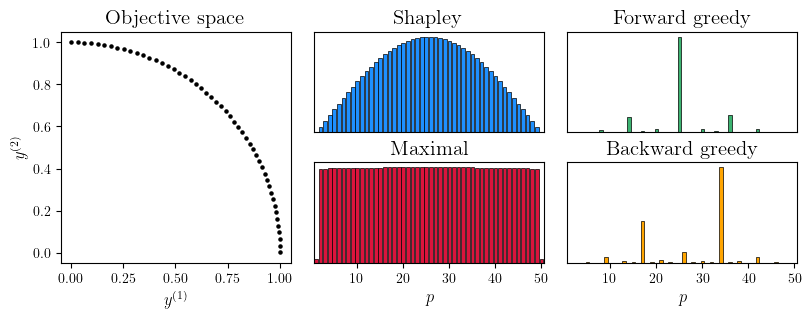

In [6]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(sY)
fig = plot_contribution_values(pf, c_values)

# Concave

In [7]:
u = torch.linspace(0.001, 0.999, num_points)

x = -torch.cos(u * torch.pi / 2) + 1
y = -torch.sin(u * torch.pi / 2) + 1

pf = torch.column_stack([x, y])

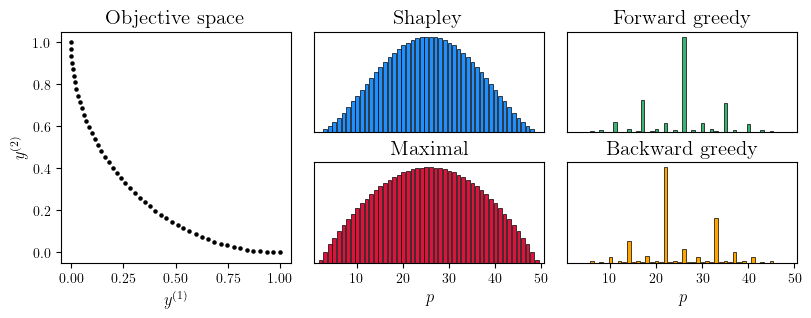

In [8]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(sY)
fig = plot_contribution_values(pf, c_values)

# Disconnected

In [9]:
from botorch.test_functions.multi_objective import ZDT3
from botorch.utils.transforms import normalize

In [10]:
M = 2
problem = ZDT3(negate=True, dim=2)
pf = problem.gen_pareto_front(n=num_points)
bounds = torch.zeros(2, M)
bounds[0, 0] = min(pf[:, 0])
bounds[0, 1] = min(pf[:, 1])
bounds[1, 0] = max(pf[:, 0])
bounds[1, 1] = max(pf[:, 1])
pf = normalize(pf, bounds=bounds)
pf = torch.flip(pf, dims=(0,))

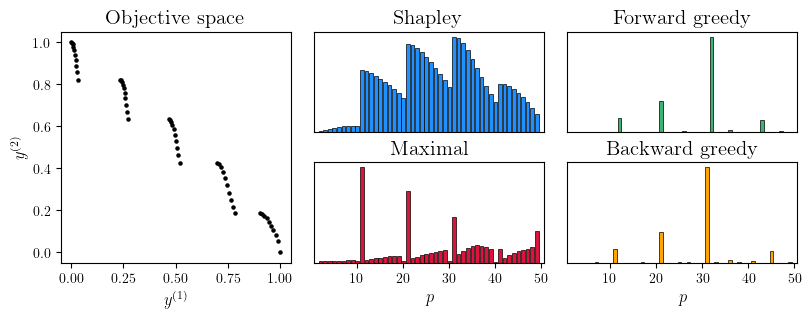

In [11]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(sY)
fig = plot_contribution_values(pf, c_values)